In [2]:
from itertools import product, combinations
import matplotlib.pyplot as plt
import numpy as np
from src import k_tree
from src.utils import data as dt
import torch
from src.k_tree import Ktree
from src.utils.data import loadData, loadData_3d
from src.metrics import Linf_simple
from src import ellipses as el

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
data = np.load('./data/ellipses/10000el_1_3.npy', allow_pickle=True)
data = np.array([data[i].ellipse.to_vector() for i in range(len(data))])


#data = rects
learning_rate = 5e-3 # 1e-2, 5e-3
k = 3
teacher_args = {
    "optimizer_lr": learning_rate,
    "epochs": 400, # 300
    "times": 20,
    "alpha": 0.1, #  projection loss 0.1
    "beta": 0.1, # latent loss 0.1
    "gamma": 0.01, # repulsive loss 0.01
    #"gamma": 0.4, # repulsive loss 0.01
    "delta": 0.01, # fuzzy scale 0.01
    "f_clk": 10, # 20
    "scale": 1, # fuzzy scale 
    "scale_flag": False,
    "number_of_centroids": k,
    "latent_size": 200,
    "encoder_activation": False,
    "encoder_depth": 5,
    "predictor_width": 5*100,
    "predictor_depth": 5,
}
n = 30
un_args = {
    "N": n,
    "M": n**2-1, # 10000 - 1
    "epsilon": 0.15 # here a layer value should be somehow included. As layers get denser  epilson should be smaller
}
student_args = {
    "optimizer_lr": 1e-2,
    "epochs": 3000, # 30000, 3000
    "width": 200,
    "depth": 5,
}

# thresshold = 0.1 * len(data)
threshold = k * 100
ktree = Ktree(threshold, data, el.distance_ellipse_2_point, teacher_args, un_args, student_args, device)
ktree.create_tree()






Creating student for node 0 that has 10000 data, which is more than the threshold 300.
Bounding box for node 0: [[-6317, 6320], [-6317, 6320]]
Creating teacher for node 0 with 3 centroids.
Training Teacher Model
Shuffling data
Epoch: 20/400.. 
 Training loss: 1532.37256.. 
 torch.mean(F): 1532.28503.. 
 Reg Proj: 0.00000.. 
 Reg Latent: 0.08749.. 
 Repulsive: 0.00005.. 
 Memory: 15.32285.. 
 Memory: 15.32285.. 
 Output: 
 [[ 992.55      679.65344 ]
 [-969.5705   -677.18115 ]
 [   8.633806   20.80529 ]]
Epoch: 40/400.. 
 Training loss: 1223.73608.. 
 torch.mean(F): 1223.18054.. 
 Reg Proj: 0.00000.. 
 Reg Latent: 0.55550.. 
 Repulsive: 0.00002.. 
 Memory: 12.23181.. 
 Memory: 12.23181.. 
 Output: 
 [[ 2718.6506   2065.8042 ]
 [-2891.013   -2187.947  ]
 [  220.65901   170.00307]]
Epoch: 60/400.. 
 Training loss: 1976.46594.. 
 torch.mean(F): 1976.42004.. 
 Reg Proj: 0.00000.. 
 Reg Latent: 0.04572.. 
 Repulsive: 0.00011.. 
 Memory: 19.76420.. 
 Memory: 19.76420.. 
 Output: 
 [[ 253.6184

In [3]:
# Report some tree stats.
leaves = ktree.get_leaves()
number_of_nodes = ktree.number_of_nodes

height = max([len(leaf.index) for leaf in leaves])
print(f"Tree height is {height}.")

leaf_sizes = [len(leaf.data) for leaf in leaves]
print(f"Created {len(leaves)} leaves with sizes")
print(leaf_sizes)
print(number_of_nodes)

Tree height is 5.
Created 10 leaves with sizes
[6680, 107, 234, 125, 270, 286, 1943, 125, 115, 115]
16


In [4]:
from src.utils import accuracy as acc

k = [1,2,5,10,100,500,1000]

for different_k in k:
    print(f"Current k is: {different_k}")
    print("Printing results for random queries")
    acc.random_queries(ktree, k = different_k)
    print("Printing results for serialized queries")
    acc.serialised_queries(ktree, k = different_k)

Current k is: 1
Printing results for random queries
The number of queries per layer are:
[300.   5.   5.   0.]
The percentage of correct predictions per layer is:
[49.33333333 49.33333333 49.33333333 49.33333333]
The number of queries per layer are:
[300.   2.   1.   0.]
The percentage of correct predictions per layer is:
[50.66666667 50.66666667 50.66666667 50.66666667]
The number of queries per layer are:
[300.   4.   2.   1.]
The percentage of correct predictions per layer is:
[44.66666667 44.66666667 44.66666667 44.66666667]
The number of queries per layer are:
[300.   4.   4.   0.]
The percentage of correct predictions per layer is:
[50.66666667 50.66666667 50.66666667 50.66666667]
The mean percentage of correct predictions per layer is:
[48.83333333 48.83333333 48.83333333 48.83333333]
Printing results for serialized queries
The number of queries per layer are:
[484.   7.   6.   4.]
The percentage of correct predictions per layer is: 
[50.2 50.2 50.2 50.2]
Current k is: 2
Printin

The percentage of correct predictions per layer is: 
[94.         89.         11.33333333  7.66666667  6.          1.33333333]
The percentage of correct predictions per layer is: 
[93.33333333 90.66666667 13.66666667 11.          8.66666667  0.66666667]
The percentage of correct predictions per layer is: 
[95.66666667 93.         16.66666667 11.66666667  8.66666667  1.        ]
The percentage of correct predictions per layer is: 
[93.66666667 89.         10.66666667  7.66666667  5.66666667  0.33333333]
The mean percentage of correct predictions is: 
[94.16666667 90.41666667 13.08333333  9.5         7.25        0.83333333]


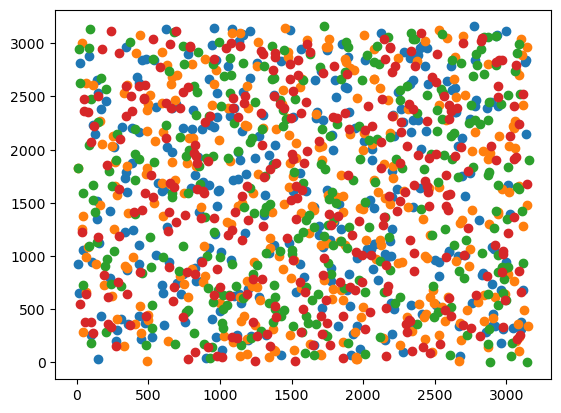

In [3]:
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

data_full = np.load('./data/ellipses/10000el_1_3.npy', allow_pickle=True)
boxes_x_min = min([data_full[i].x_min for i in range(len(data_full))])
boxes_x_max = max([data_full[i].x_max for i in range(len(data_full))])
boxes_y_min = min([data_full[i].y_min for i in range(len(data_full))])
boxes_y_max = max([data_full[i].y_max for i in range(len(data_full))])

while times < 4:
    # now lets create randomly N points in the space 0-300, 0-300
    n = 300
    random_p = torch.zeros(n, 2)
    x_lim = [boxes_x_min, boxes_x_max]
    y_lim = [boxes_y_min, boxes_y_max]


    for i in range(n):
        random_p[i] = torch.Tensor([np.random.randint(*x_lim), np.random.randint(*y_lim)])
        
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        brute_force = ktree.root.query(query_point)

        for j, pred in enumerate(preds_per_layer):
            if np.array_equal(pred, brute_force):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)

The percentage of correct predictions per layer is: 
[93.66666667 90.         11.33333333  9.33333333  7.33333333  0.66666667]
The percentage of correct predictions per layer is: 
[91.33333333 90.         14.         10.33333333  9.66666667  1.66666667]
The percentage of correct predictions per layer is: 
[92.33333333 89.33333333 11.66666667  7.66666667  7.          0.66666667]
The percentage of correct predictions per layer is: 
[91.33333333 86.33333333 10.          8.33333333  7.66666667  1.33333333]
The mean percentage of correct predictions is: 
[92.16666667 88.91666667 11.75        8.91666667  7.91666667  1.08333333]


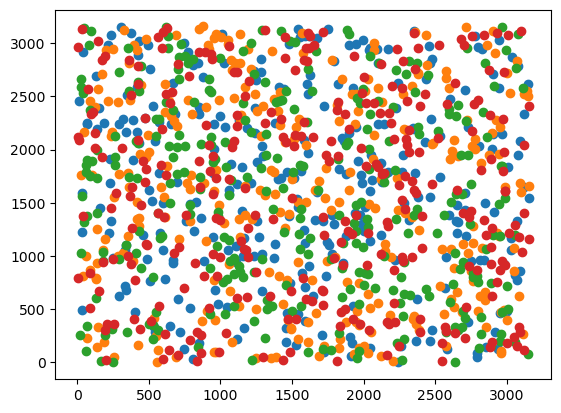

In [4]:
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

data_full = np.load('./data/ellipses/10000el_1_3.npy', allow_pickle=True)
boxes_x_min = min([data_full[i].x_min for i in range(len(data_full))])
boxes_x_max = max([data_full[i].x_max for i in range(len(data_full))])
boxes_y_min = min([data_full[i].y_min for i in range(len(data_full))])
boxes_y_max = max([data_full[i].y_max for i in range(len(data_full))])

while times < 4:
    # now lets create randomly N points in the space 0-300, 0-300
    n = 300
    random_p = torch.zeros(n, 2)
    x_lim = [boxes_x_min, boxes_x_max]
    y_lim = [boxes_y_min, boxes_y_max]


    for i in range(n):
        random_p[i] = torch.Tensor([np.random.randint(*x_lim), np.random.randint(*y_lim)])
        
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        k_nearest_neighbors = ktree.root.query(query_point, k=2)

        for j, pred in enumerate(preds_per_layer):
            if any(np.array_equal(pred[0], k_nearest_neighbors[ki]) for ki in range(2)):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)

The percentage of correct predictions per layer is: 
[93.66666667 89.         10.66666667  8.66666667  8.          1.66666667]
The percentage of correct predictions per layer is: 
[91.33333333 88.         13.66666667 11.          9.          1.66666667]
The percentage of correct predictions per layer is: 
[91.         87.66666667 12.66666667 10.66666667  8.66666667  3.        ]
The percentage of correct predictions per layer is: 
[94.         91.         14.33333333 11.33333333  9.          1.66666667]
The mean percentage of correct predictions is: 
[92.5        88.91666667 12.83333333 10.41666667  8.66666667  2.        ]


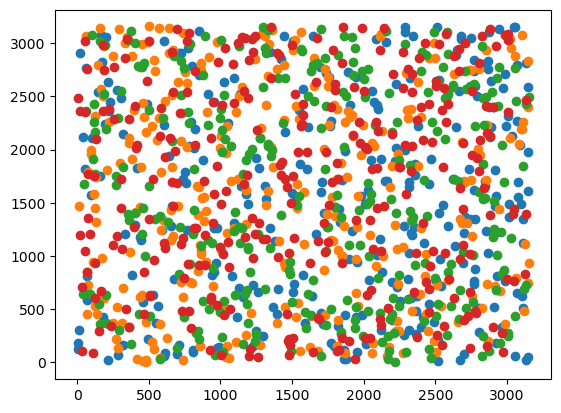

In [5]:
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

data_full = np.load('./data/ellipses/10000el_1_3.npy', allow_pickle=True)
boxes_x_min = min([data_full[i].x_min for i in range(len(data_full))])
boxes_x_max = max([data_full[i].x_max for i in range(len(data_full))])
boxes_y_min = min([data_full[i].y_min for i in range(len(data_full))])
boxes_y_max = max([data_full[i].y_max for i in range(len(data_full))])

while times < 4:
    # now lets create randomly N points in the space 0-300, 0-300
    n = 300
    random_p = torch.zeros(n, 2)
    x_lim = [boxes_x_min, boxes_x_max]
    y_lim = [boxes_y_min, boxes_y_max]


    for i in range(n):
        random_p[i] = torch.Tensor([np.random.randint(*x_lim), np.random.randint(*y_lim)])
        
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        k_nearest_neighbors = ktree.root.query(query_point, k=5)

        for j, pred in enumerate(preds_per_layer):
            if any(np.array_equal(pred[0], k_nearest_neighbors[ki]) for ki in range(5)):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)

The percentage of correct predictions per layer is: 
[94.33333333 89.33333333 17.33333333 15.         13.          2.        ]
The percentage of correct predictions per layer is: 
[95.33333333 90.66666667 14.66666667 13.         12.33333333  1.66666667]
The percentage of correct predictions per layer is: 
[95.33333333 92.         14.66666667 14.         11.33333333  2.        ]
The percentage of correct predictions per layer is: 
[93.66666667 89.33333333 16.33333333 14.33333333 12.66666667  1.        ]
The mean percentage of correct predictions is: 
[94.66666667 90.33333333 15.75       14.08333333 12.33333333  1.66666667]


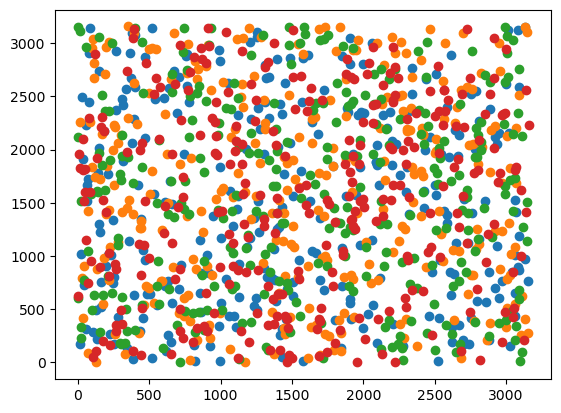

In [6]:
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

data_full = np.load('./data/ellipses/10000el_1_3.npy', allow_pickle=True)
boxes_x_min = min([data_full[i].x_min for i in range(len(data_full))])
boxes_x_max = max([data_full[i].x_max for i in range(len(data_full))])
boxes_y_min = min([data_full[i].y_min for i in range(len(data_full))])
boxes_y_max = max([data_full[i].y_max for i in range(len(data_full))])

while times < 4:
    # now lets create randomly N points in the space 0-300, 0-300
    n = 300
    random_p = torch.zeros(n, 2)
    x_lim = [boxes_x_min, boxes_x_max]
    y_lim = [boxes_y_min, boxes_y_max]


    for i in range(n):
        random_p[i] = torch.Tensor([np.random.randint(*x_lim), np.random.randint(*y_lim)])
        
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        k_nearest_neighbors = ktree.root.query(query_point, k=10)

        for j, pred in enumerate(preds_per_layer):
            if any(np.array_equal(pred[0], k_nearest_neighbors[ki]) for ki in range(10)):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)

The percentage of correct predictions per layer is: 
[92.8 88.6 15.8  9.2  7.8  1.4]
The mean percentage of correct predictions is: 
[92.8 88.6 15.8  9.2  7.8  1.4]


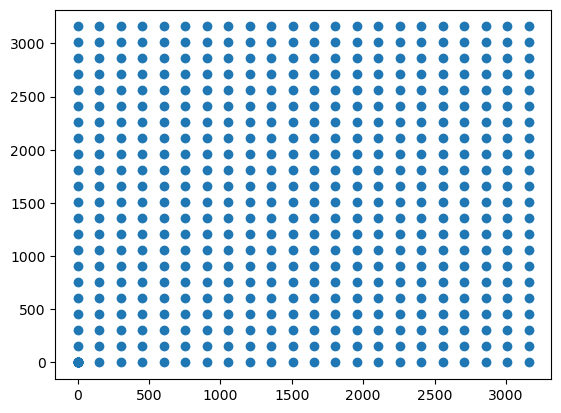

In [7]:
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

data_full = np.load('./data/ellipses/10000el_1_3.npy', allow_pickle=True)
boxes_x_min = min([data_full[i].x_min for i in range(len(data_full))])
boxes_x_max = max([data_full[i].x_max for i in range(len(data_full))])
boxes_y_min = min([data_full[i].y_min for i in range(len(data_full))])
boxes_y_max = max([data_full[i].y_max for i in range(len(data_full))])

while times < 1:
    nop =  500
    random_p = torch.zeros(nop, 2)
    x_lim = [boxes_x_min, boxes_x_max]
    y_lim = [boxes_y_min, boxes_y_max]
    num = int(np.sqrt(nop))
    for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], num)):
        for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], num)):
            random_p[i*num+j] = torch.Tensor([x, y])
    
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        brute_force = ktree.root.query(query_point)

        for j, pred in enumerate(preds_per_layer):
            if np.array_equal(pred, brute_force):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)

In [8]:
# Report some tree stats.
leaves = ktree.get_leaves()
number_of_nodes = ktree.number_of_nodes

height = max([len(leaf.index) for leaf in leaves])
print(f"Tree height is {height}.")

leaf_sizes = [len(leaf.data) for leaf in leaves]
print(f"Created {len(leaves)} leaves with sizes")
print(leaf_sizes)
print(number_of_nodes)

Tree height is 6.
Created 18 leaves with sizes
[7513, 147, 76, 128, 177, 181, 232, 272, 138, 103, 74, 168, 86, 240, 99, 171, 88, 107]
27


The percentage of correct predictions per layer is: 
[93.2 89.  16.   9.6  8.   1.4]
The mean percentage of correct predictions is: 
[93.2 89.  16.   9.6  8.   1.4]


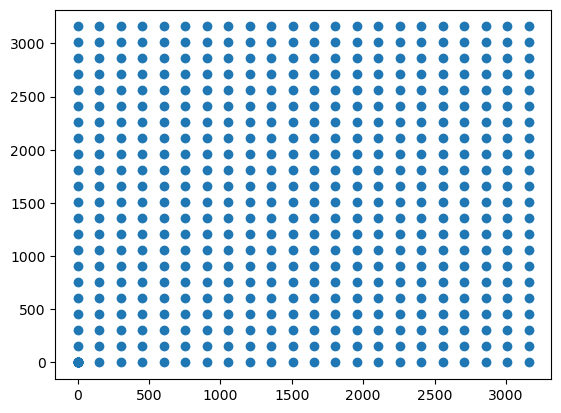

In [9]:
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

data_full = np.load('./data/ellipses/10000el_1_3.npy', allow_pickle=True)
boxes_x_min = min([data_full[i].x_min for i in range(len(data_full))])
boxes_x_max = max([data_full[i].x_max for i in range(len(data_full))])
boxes_y_min = min([data_full[i].y_min for i in range(len(data_full))])
boxes_y_max = max([data_full[i].y_max for i in range(len(data_full))])

while times < 1:
    nop =  500
    random_p = torch.zeros(nop, 2)
    x_lim = [boxes_x_min, boxes_x_max]
    y_lim = [boxes_y_min, boxes_y_max]
    num = int(np.sqrt(nop))
    for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], num)):
        for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], num)):
            random_p[i*num+j] = torch.Tensor([x, y])
    
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        k_nearest_neighbors = ktree.root.query(query_point, k=2)

        for j, pred in enumerate(preds_per_layer):
            if any(np.array_equal(pred[0], k_nearest_neighbors[ki]) for ki in range(2)):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)